--- 
description: Here we show how to solve minimum spanning tree problem with maximum degree constraint using JijZept and JijModeling.
---

# Minimum Spanning Tree with a Maximum Degree Constraint

We show how to solve the minimum spanning tree problem with a maximum degree constraint using JijZept and JijModeling. 
This problem is also mentioned in 8.1. Minimal Spanning Tree with a Maximal Degree Constraint on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is Minimum Spanning Tree with a Maximum Degree Constraint?

The minimum spanning tree problem is defined as follows. 
Given an undirected graph $G = (V, E)$, where each edge $(uv) \in E$ is associated with a cost $c_{uv}$, construct the spanning tree (a tree that contains all vertices) $T \subseteq G$ such that the cost of $T$

$$
c(T) = \sum_{(uv) \in E_T} c_{uv}
$$

is minimized if such a tree exists.
One can add a degree constraint that forces each degree of vertex in $T$ to be $\leq \Delta$.
In other words, given a graph, the minimum spanning tree is the tree that connects all the nodes with the minimum total edge weight, and the maximum degree constraint ensures that no vertex in the tree has a degree that is greater than specified value.

### Example
Let us consider a simple graph shown below.
Suppose we want to find the minimum spanning tree of the left graph subject to a maximum degree constraint 3.
The solution to this problem is given in the right;
the edges in this tree have a total weight 8, which is the minimum possible, and the maximum degree constraint is obviously satisfied.
![](./assets/21-example.jpg)


<!-- # import networkx as nx
# import matplotlib.pyplot as plt

# # Create a graph
# G = nx.Graph()

# # Add nodes
# G.add_nodes_from(['A', 'B', 'C', 'D'])

# # Add edges
# G.add_edge('A', 'B', weight=3)
# # G.add_edge('A', 'D', weight=4)
# G.add_edge('B', 'C', weight=2)
# G.add_edge('D', 'C', weight=3)
# # G.add_edge('B', 'D', weight=5)

# # Set node positions
# pos = {'A': (-1, 0), 'B': (0, 1), 'C': (1, 0), 'D': (0, -1)}

# # Draw graph
# nx.draw(G, pos, with_labels=True, font_weight='bold')

# # Draw edge weights
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# # Show plot
# plt.show() -->


## Mathematical model
We first place a binary variable $x_{uv}$ on each edge to show whether or not the edge is included in $T$;
*i.e.* $x_{uv} = 1$ means that the edge $e = (uv)$ is included in our minimum spanning tree $T$.

**Constraint1: Each vertex can have at most $\Delta$ edges**

The degree of any vertex in the graph cannot exceed $\Delta$.
Note that we have also a lower bound condition for the degree of each vertex, because, in a spanning tree, each vertex must have at least one edge.

$$
\quad 1 \leq \sum_{(uv),(vu) \in E} x_{uv} \leq \Delta \quad \forall u \in V.
$$

Note that the notation in the summation is meant to include both $x_{uv}$ and $x_{vu}$.

**Constraint2: The tree is spanning**

We promise that the selected edges form a tree with all vertices included;
if the number of edges in $T$ is less than $|V|-1$, $T$ does not include all vertices,
and if the number of edges in $T$ is greater than $|V|-1$, $T$ is not a tree (there are loops in such cases).

$$
\quad \sum_{(uv) \in E} x_{uv} = |V|-1.
$$

**Constraint3: Cut constraint**

This constraint ensures that the solution is connected and acyclic.

$$
\quad \sum_{(uv) \in E(S)} x_{uv} \leq |S| - 1 \quad \forall S \subset G,
$$

where $S$ represents a subgraph of the given $G$, and where $E(S)$ represents the set of edges that are contained in $S$.

**Objective function**

We set the objective function so that the total weight of $T$ is minimized.

$$
\quad \min \sum_{uv \in E} c_{uv}x_{uv}.
$$


## Modeling by JijModeling

Next, we show how to implement above equations using JijModeling.
We first define the variables in the mathematical model described above.

In [1]:
import jijmodeling as jm

#define variables
V = jm.Placeholder('V')  # number of vertices
E = jm.Placeholder('E', ndim=2)  # set of edges
num_E = E.shape[0]
C = jm.Placeholder('C', ndim=2)  # cost between each vertex
D = jm.Placeholder('D')  # number of degrees
S = jm.Placeholder('S', ndim=3)  # list of set of subgraph edges
num_S = S.shape[0]
S_nodes = jm.Placeholder('S_nodes', ndim=1)  # list of number of subgraphs vertices

x = jm.BinaryVar('x', shape=(num_E,))

v = jm.Element('v', V)  # subscripts for verteces
e = jm.Element('e', num_E)  # subscripts for edges
i_s = jm.Element('i_s', num_S)
e_s = jm.Element('e_s', S[i_s].shape[0])  # subscripts of edges in S

The constraints and the objective function are written as:


In [2]:
problem = jm.Problem("minimum spanning tree with a maximum degree constraint")
problem += jm.Constraint('const1-1', jm.sum((e, (E[e][0]==v)|(E[e][1]==v)), x[e]) >= 1, forall=v)
problem += jm.Constraint('const1-2', jm.sum((e, (E[e][0]==v)|(E[e][1]==v)), x[e]) <= D, forall=v)
problem += jm.Constraint('const2', x[:].sum() == V-1)
problem += jm.Constraint('const3',jm.sum(e_s, x[e_s]) <= S_nodes[i_s] - 1, forall = i_s)
problem += jm.sum(e, C[E[e][0]][E[e][1]]*x[e])

On Jupyter Notebook, one can check the problem statement in a human-readable way by hitting


In [3]:
problem 

## Prepare an instance

We prepare a graph using [NetworkX](https://networkx.org/). 
As an example, we create a random complete graph (a graph where all vertices are connected to each other).


In [4]:
import itertools
import networkx as nx
import numpy as np

np.random.seed(seed=0)

# set the number of vertices
inst_V = 5
# set the number of degree
inst_D = 2

# set the probability of rewiring edges
p_rewire = 0.2
# set the number of nearest neighbors
k_neighbors = 4
# create a connected graph
inst_G = nx.connected_watts_strogatz_graph(inst_V, k_neighbors, p_rewire)
# add random costs to the edges
for u, v in inst_G.edges():
    inst_G[u][v]['weight'] = np.random.randint(1, 10)

# create a 2D array for the costs
inst_C = np.zeros((inst_V, inst_V))
for u, v in inst_G.edges():
    inst_C[u][v] = inst_G[u][v]['weight']
    inst_C[v][u] = inst_G[u][v]['weight']
# set diagonal elements to infinity
np.fill_diagonal(inst_C, np.inf)

# get information of edges
inst_E = [list(edge) for edge in inst_G.edges]

# get subgraphs and their edges
sub_nodes = []
sub_edges = []
# get connected subgraphs that have at least 2 nodes and have less nodes than the original graph
for num_nodes in range(2, inst_G.number_of_nodes()):
    for comb in (inst_G.subgraph(selected_nodes) for selected_nodes in itertools.combinations(inst_G, num_nodes)):
        if nx.is_connected(comb):
            sub_edges.append(comb.edges)
            sub_nodes.append(comb.nodes)
inst_S = [list(edgeview) for edgeview in sub_edges]
inst_S = [[list(t) for t in inner_list] for inner_list in inst_S]  # convert tuples into lists
# get the number of vertices in each subgraph
inst_S_nodes = [len(x) for x in sub_nodes]

instance_data = {'V': inst_V, 'D': inst_D, 'E': inst_E, 'C': inst_C, 'S': inst_S, 'S_nodes': inst_S_nodes}


This graph is shown below.

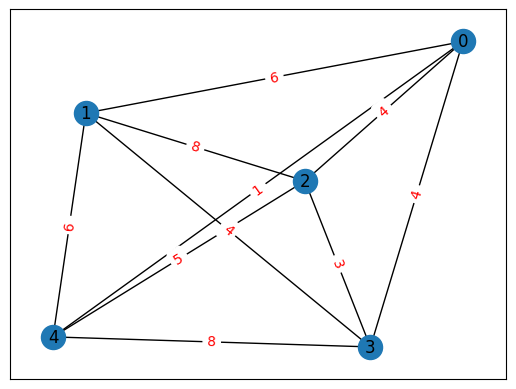

In [5]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(inst_G)
nx.draw_networkx(inst_G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(inst_G, 'weight')
nx.draw_networkx_edge_labels(inst_G, pos, edge_labels=edge_labels, font_color='red')

plt.show()

## Solve by JijZept's SA

We solve this problem using JijSASampler.
We also turn on a parameter search function by setting `search=True`.


In [6]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="../../../config.toml")
# solve problem
response = sampler.sample_model(problem, instance_data, multipliers={"const1-1": 0.5, "const1-2": 0.5, "const2": 0.5, "const3": 0.5}, search=True, num_reads=100)

## Visualize the solution

The optimized solution can be seen as below.


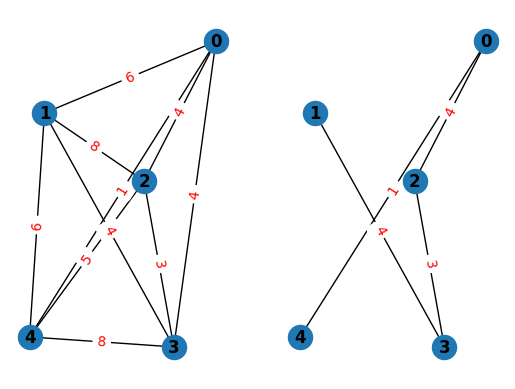

In [8]:
# get sampleset
sampleset = response.get_sampleset()
# extract feasible samples
feasible_samples = sampleset.feasibles()
# get the values of feasible objectives
feasible_objectives = [sample.eval.objective for sample in feasible_samples]
if len(feasible_objectives) == 0:
    print("No feasible samples found ...")
else:
    # get the index of the lowest feasible objective
    lowest_index = np.argmin(feasible_objectives)
    # get the lowest feasible solution
    lowest_solution = feasible_samples[lowest_index].var_values["x"].values
    # get the indices of x == 1
    x_indices = [key[0] for key in lowest_solution.keys()]
    # set edge color list (x==1: black, x==0: white)
    inst_E = np.array(inst_E)
    mask = inst_E[:, 0] > inst_E[:, 1]
    inst_E[mask] = inst_E[mask][: , : :-1]
    edge_colors = np.where(np.isin(np.arange(len(inst_E)), x_indices), 'black', 'white').tolist()
    # draw figure
    plt.subplot(121)
    plt.axis('off')
    nx.draw(inst_G, pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(inst_G, pos, edge_labels=edge_labels, font_color='red')
    plt.subplot(122)
    plt.axis('off')
    inst_H = inst_G.copy()
    for i in range(len(inst_H.edges)):
        if edge_colors[i] == 'white':
            inst_H.remove_edge(*list(inst_G.edges)[i])
    nx.draw(inst_H, pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edge_labels(inst_H, pos, edge_labels=nx.get_edge_attributes(inst_H, 'weight'), font_color='red')

As expected, we have obtained the minimum spanning tree that satisfies the maximum degree constraint.

The Steiner tree problem, a similar problem to the one described in this page, would be an advanced practice.
The problem statement is as follows.
Given costs $c_{uv}$, find the minimum spanning tree for a subset of the vertices $U \subset V$, where the usage of nodes that are not contained in $U$ is one's option.
To solve this problem, one can use the same Hamiltonian as for the minimum spanning tree problem except for additional binary variables $y_v$ for $v \notin U$, which show whether or not a node $v$ is included in the resulting tree.
